## Test the computational complexity of the different algorithms

ie. compare how the different algorithms scale with the number of datapoints (and maybe later also with dimension, we only have data sets of dimension 2 and 3 though). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_spiral_data, load_aggregation_data, load_birch1_data, load_birch3_data, load_compound_data, load_flame_data, load_pathbased_data, load_sets_data, scale_data, load_fuzzy_data
from timeit import default_timer as timer 
from clustertools.models.distance import KMeans, Regspace
from clustertools.models.similarity import SpectralClustering, HierarchicalClustering, AffinityPropagation
from clustertools.models.density import MeanShift, DBSCAN
from clustertools.models.fuzzy import FuzzyCMeans
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
#set font sizes for matplotlib plots and seaborn plots
fontsizeset = 20
rc={'axes.labelsize': fontsizeset, 'font.size': fontsizeset, 'legend.fontsize': fontsizeset, 'axes.titlesize': fontsizeset,'xtick.labelsize': fontsizeset, 'ytick.labelsize': fontsizeset}
sns.mpl.rcParams.update(rc)

In [3]:
spiral=load_spiral_data(scale = 'True')
aggr=load_aggregation_data(scale = 'True')
compound = load_compound_data(scale = 'True')
fuzzy = load_fuzzy_data(scale = 'True')
fuzzy = fuzzy[np.arange(0,2309,2),:]
pathbased = load_pathbased_data(scale = 'True')
dataset = [spiral, aggr, compound, fuzzy, pathbased]

very ugly function below calling all the different algorithms and using them on a test data set with different number of datapoints. 

In [10]:
def computational_complexity(datapoints, data, maxnbr):
    '''
    
    Args: 
    datapoints: array containing the different number of datapoints we want to cluster, max(datapoints)< # data points in data
    data: data to cluster
    maxnbr: for the slower clustering algorithms, don't measure the complexity for more than maxnbr data points
    
    
    '''
    time = np.zeros((9, np.shape(datapoints)[0]))
    #2 dimensions only for now
    for i,nbr in enumerate(datapoints):
        #fuzzy c means
        start_time = timer()
        alg = FuzzyCMeans(data[np.random.randint(1,  np.shape(data)[0], nbr),:], c=4, verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[0,i]=time_taken 
        #mean shift
        start_time = timer()
        alg = MeanShift(data[np.random.randint(1,  np.shape(data)[0], nbr),:], verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[1,i]=time_taken 
        #k means
        start_time = timer()
        alg = KMeans(data[np.random.randint(1,  np.shape(data)[0], nbr),:],4, verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[2,i]=time_taken         
        #RegSpace
        start_time = timer()
        alg = Regspace(data[np.random.randint(1,  np.shape(data)[0], nbr),:],10,.3, verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[3,i]=time_taken 
        #Spectral Clustering
        if nbr<maxnbr:
            start_time = timer()
            alg = SpectralClustering(data[np.random.randint(1,  np.shape(data)[0], nbr),:],5,similarity_measure='gaussian',bandwidth=.3,laplacian='normalized', verbose=False)
            alg.fit()
            time_taken = timer() - start_time
            time[4,i]=time_taken
        #spectral clustering is very small, for more than a certain number of datapoints stop clustering and measuring time
        else: 
            time[4,i]=float('nan')
        #dbscan
        start_time = timer()
        alg = DBSCAN(data[np.random.randint(1,  np.shape(data)[0], nbr),:],eps=0.03, minPts=10, verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[5,i]=time_taken
        #hierarchical
        if nbr<maxnbr:
            start_time = timer()
            alg = HierarchicalClustering(data[np.random.randint(1,  np.shape(data)[0], nbr),:],k=3, verbose=False)
            alg.fit()
            time_taken = timer() - start_time
            time[6,i]=time_taken
        else: 
            time[6,i]=float('nan')
        #k means ++
        start_time = timer()
        alg = KMeans(data[np.random.randint(1,  np.shape(data)[0], nbr),:],4, method = 'kmeans++', verbose=False)
        alg.fit()
        time_taken = timer() - start_time
        time[7,i]=time_taken 
        #affinity
        if nbr<maxnbr:
            start_time = timer()
            alg = AffinityPropagation(data[np.random.randint(1,  np.shape(data)[0], nbr),:],verbose=False)
            alg.fit()
            time_taken = timer() - start_time
            time[8,i]=time_taken 
        else: 
            time[8,i]=float('nan')       
    method_label = ['Fuzzy C-Means', 'Mean Shift', 'K-Means','RegSpace','Spectral Clustering', 'DBScan','Hierarchical', 'K-Means++', 'Affinity Propagation']                          
    return time,  method_label       

In [11]:
birch3=load_birch3_data(scale = 'True')
data= birch3[:10100,:2]
#the n for which to measure the time
datapoints = np.arange(0, np.shape(data)[0], 500)[1:]

######do new computation of complexity
#time, method_label = computational_complexity(datapoints, data, 2600)
#save the results, just in case
#np.save('images/time', time)
#np.save('images/method', method_label)

######load data from previous computation
method_label=np.load('images/method.npy')
time=np.load('images/time.npy')

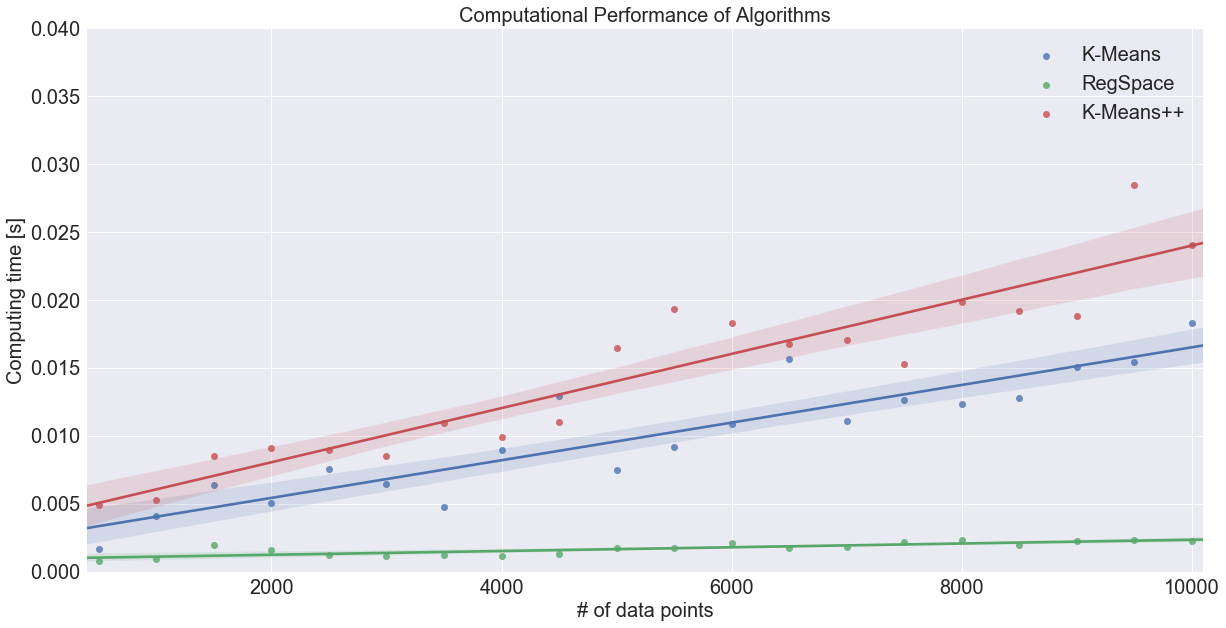

In [6]:
#fast algorithms
fig, ax = plt.subplots(figsize = (20,10))
#indexrange=range(len(method_label))
indexrange = [2,3,7]
for i in indexrange:
    sns.regplot(x=datapoints, y=time[i,:], ax=ax, label=method_label[i])
plt.gca().axis([min(datapoints)-100, max(datapoints)+100, 0, 0.04])
plt.gca().set_xlabel('# of data points', fontsize = fontsizeset)
plt.gca().set_ylabel('Computing time [s]', fontsize = fontsizeset)
plt.title('Computational Performance of Algorithms', fontsize = fontsizeset)
plt.legend(fontsize = fontsizeset)
plt.savefig('images/complex.png')

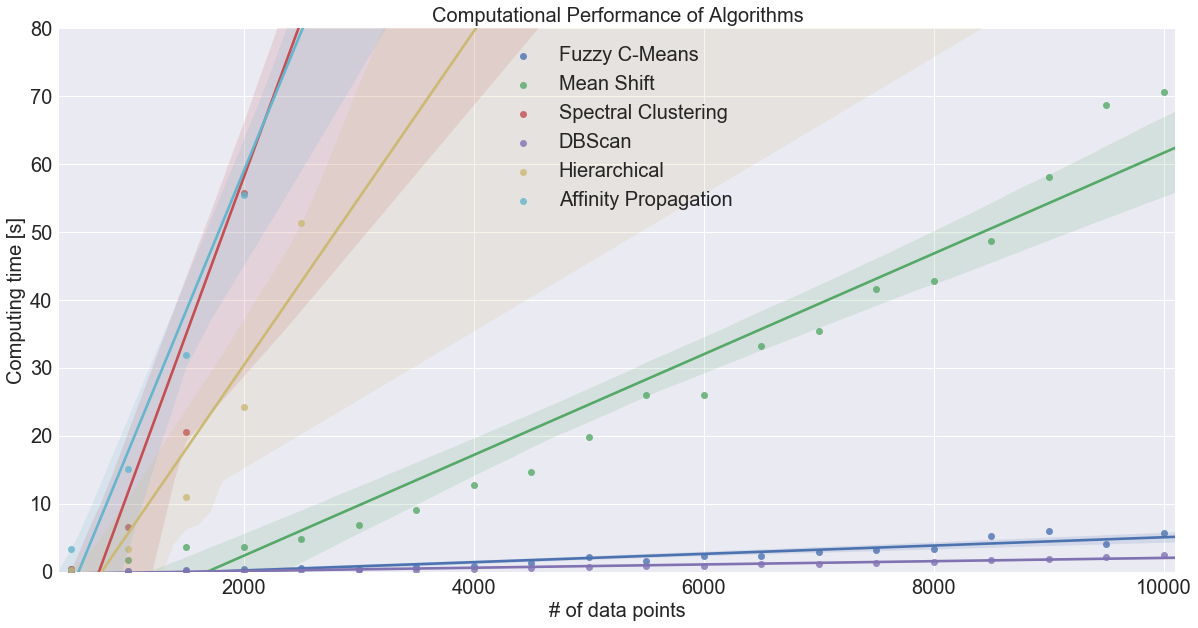

In [12]:
#slow algorithms
fig, ax = plt.subplots(figsize = (20,10))
#indexrange=range(len(method_label))
indexrange = [0,1,4,5,6,8]
for i in indexrange:
    sns.regplot(x=datapoints, y=time[i,:], ax=ax, label=method_label[i])

plt.gca().axis([min(datapoints)-100, max(datapoints)+100, 0, 80])
plt.gca().set_xlabel('# of data points', fontsize = fontsizeset)
plt.gca().set_ylabel('Computing time [s]', fontsize = fontsizeset)
plt.title('Computational Performance of Algorithms', fontsize = fontsizeset)
plt.legend(fontsize = fontsizeset)
plt.savefig('images/complex2.png')

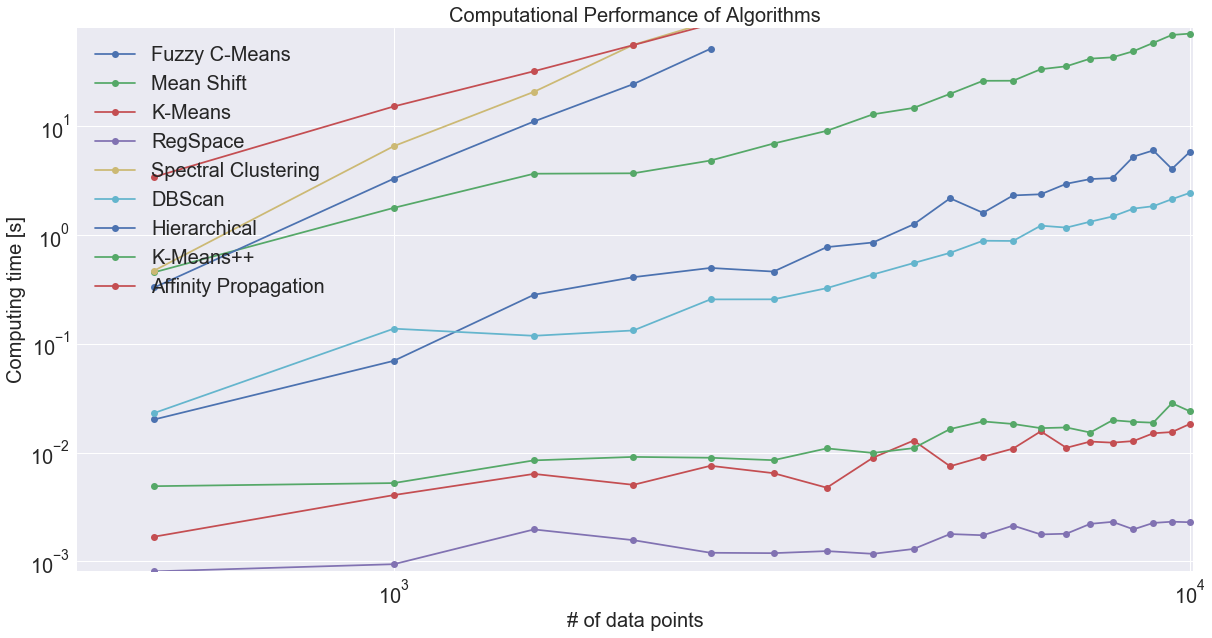

In [13]:
fig, ax = plt.subplots(figsize = (20,10))
indexrange=range(len(method_label))
#loglogplot
ax.set(xscale="log",yscale="log") 
for i in indexrange:
    plt.plot(datapoints, time[i,:],'-o', label=method_label[i])
plt.xlim(1e3, 1e4)
plt.gca().axis([min(datapoints)-100, max(datapoints)+100, 0, 80])
plt.gca().set_xlabel('# of data points', fontsize = fontsizeset)
plt.gca().set_ylabel('Computing time [s]', fontsize = fontsizeset)
plt.title('Computational Performance of Algorithms', fontsize = fontsizeset)
plt.legend(fontsize = fontsizeset)
plt.savefig('images/complexlog2.png')

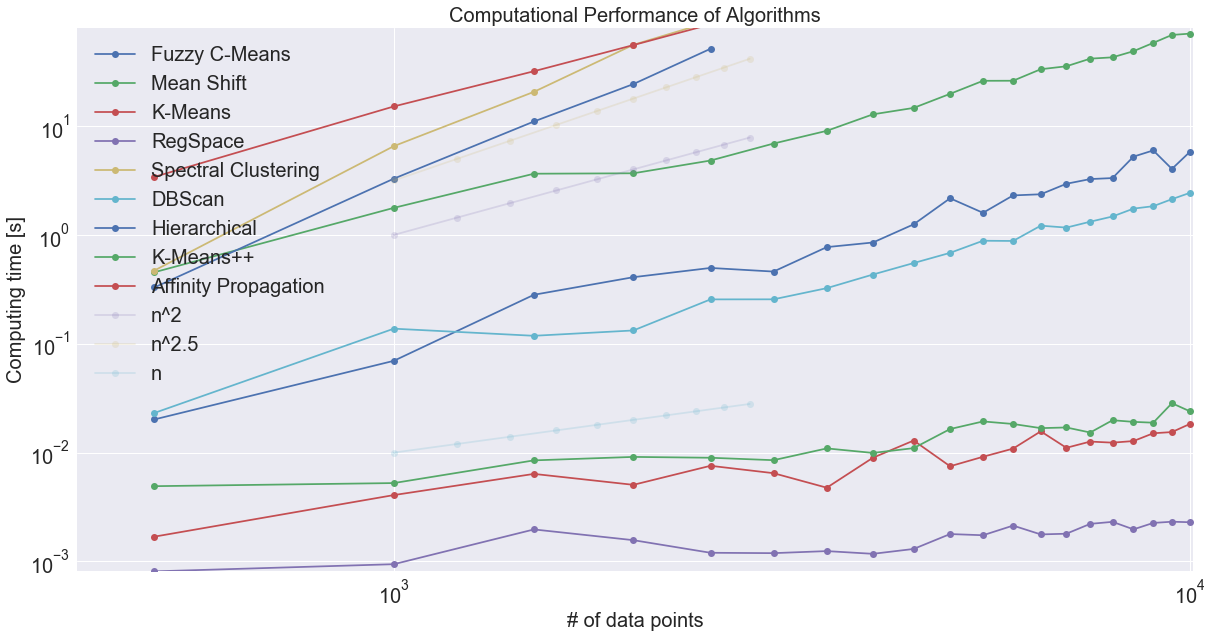

In [14]:
fig, ax = plt.subplots(figsize = (20,10))
indexrange=range(len(method_label))
#loglogplot
ax.set(xscale="log",yscale="log") 
for i in indexrange:
    plt.plot(datapoints, time[i,:],'-o', label=method_label[i])
plt.xlim(1e3, 1e4)

#some reference curves
plt.plot(np.arange(1000,3000,200),0.000001*np.arange(1000,3000,200)**2, '-o',alpha=0.2,label="n^2")
plt.plot(np.arange(1000,3000,200),0.0000001*np.arange(1000,3000,200)**2.5, '-o',alpha=0.2,label="n^2.5")
plt.plot(np.arange(1000,3000,200),0.00001*np.arange(1000,3000,200), '-o',alpha=0.2,label="n")

plt.gca().axis([min(datapoints)-100, max(datapoints)+100, 0, 80])
plt.gca().set_xlabel('# of data points', fontsize = fontsizeset)
plt.gca().set_ylabel('Computing time [s]', fontsize = fontsizeset)
plt.title('Computational Performance of Algorithms', fontsize = fontsizeset)
plt.legend(fontsize = fontsizeset)
plt.savefig('images/complexlog2.png')